# 解答

演習問題の「解答例」として、実行可能なコードをまとめたものです。
練習問題ごとにコメントで番号を付けています。


## 0. 事前準備（環境とライブラリ）

In [1]:
# 必要ライブラリのインポート
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from lightgbm import LGBMRegressor


## 2. データの読み込みと概要確認（練習問題の解答）

In [2]:
# データ読み込み
df = sns.load_dataset("diamonds")

# 練習問題 2-1: df.info() と df.describe() でデータの内容を確認
print("=== df.info() ===")
df.info()
print("\n=== df.describe() ===")
display(df.describe())


=== df.info() ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   carat    53940 non-null  float64 
 1   cut      53940 non-null  category
 2   color    53940 non-null  category
 3   clarity  53940 non-null  category
 4   depth    53940 non-null  float64 
 5   table    53940 non-null  float64 
 6   price    53940 non-null  int64   
 7   x        53940 non-null  float64 
 8   y        53940 non-null  float64 
 9   z        53940 non-null  float64 
dtypes: category(3), float64(6), int64(1)
memory usage: 3.0 MB

=== df.describe() ===


,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


In [3]:
# 練習問題 2-2: 行数と列数の取得
n_rows, n_cols = df.shape
print(f"行数: {n_rows}")
print(f"列数: {n_cols}")


行数: 53940
列数: 10


cut の件数分布:


cut
Ideal        21551
Premium      13791
Very Good    12082
Good          4906
Fair          1610
Name: count, dtype: int64

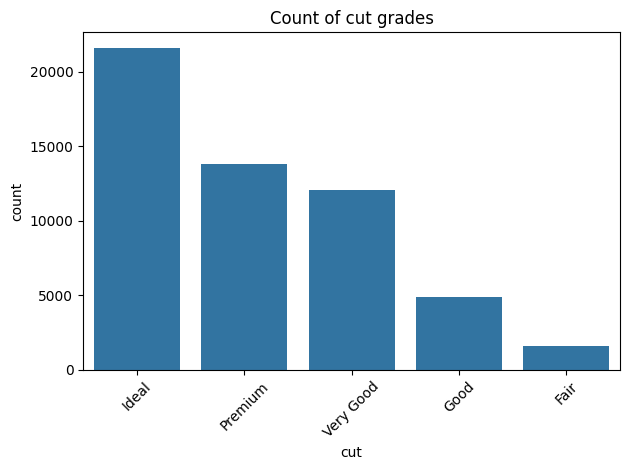


最も多い cut グレード: Ideal


In [4]:
# 練習問題 2-3: cut の分布を可視化し、最も多いグレードを確認
cut_counts = df["cut"].value_counts()
print("cut の件数分布:")
display(cut_counts)

plt.figure()
sns.countplot(x="cut", data=df, order=cut_counts.index)
plt.title("Count of cut grades")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\n最も多い cut グレード:", cut_counts.idxmax())


count    53940.000000
mean      3932.799722
std       3989.439738
min        326.000000
25%        950.000000
50%       2401.000000
75%       5324.250000
max      18823.000000
Name: price, dtype: float64
中央値: 2401.0
平均値: 3932.8
最大値: 18823.0


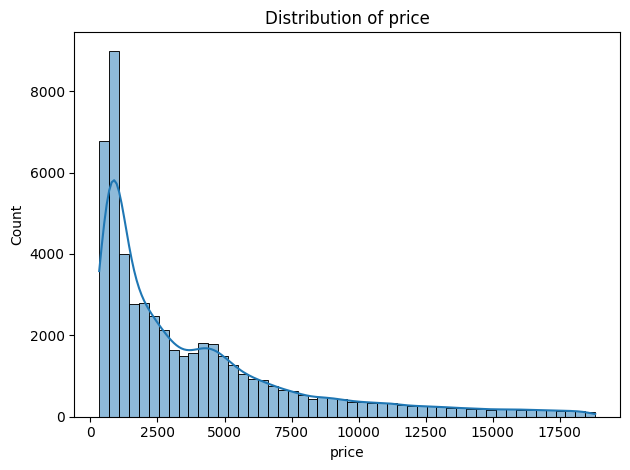

In [5]:
# 練習問題 2-4: price の記述統計と分布の確認
price_desc = df["price"].describe()
print(price_desc)

median_price = price_desc["50%"]
mean_price = price_desc["mean"]
max_price = price_desc["max"]

print(f"中央値: {median_price:.1f}")
print(f"平均値: {mean_price:.1f}")
print(f"最大値: {max_price:.1f}")

plt.figure()
sns.histplot(df["price"], bins=50, kde=True)
plt.title("Distribution of price")
plt.xlabel("price")
plt.tight_layout()
plt.show()


# 多くのサンプルが比較的低価格帯に集中し、右側に長い尾を引く右に歪んだ分布になっていることがわかる。


## 3. 相関の確認（練習問題の解答）

In [6]:
# 練習問題 3-1: carat と price のピアソン相関係数
corr_carat_price = df[["carat", "price"]].corr(method="pearson").loc["carat", "price"]
print(f"carat と price のピアソン相関係数: {corr_carat_price:.3f}")


carat と price のピアソン相関係数: 0.922


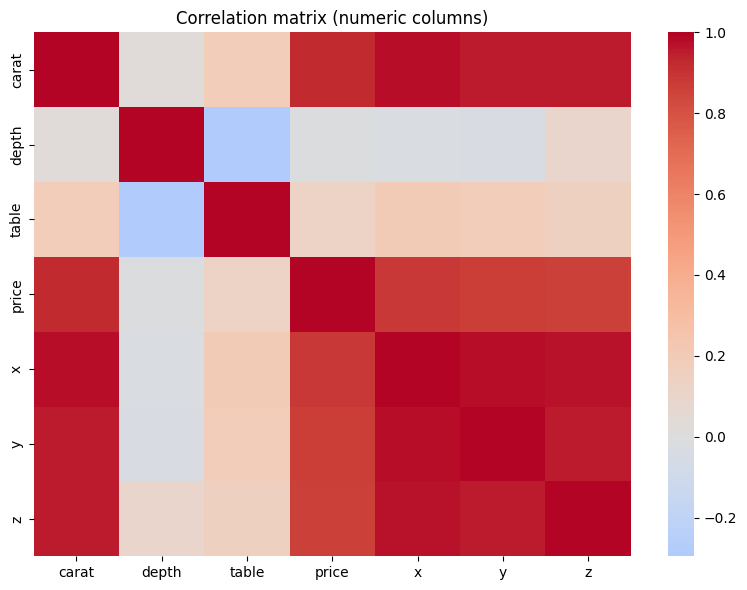

price と相関が高い上位 3 特徴量:


carat    0.921591
x        0.884435
y        0.865421
Name: price, dtype: float64

In [7]:
# 練習問題 3-2: 相関行列のヒートマップと price との相関が高い上位 3 特徴量
corr_matrix = df.corr(numeric_only=True)
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, cmap="coolwarm", center=0, annot=False)
plt.title("Correlation matrix (numeric columns)")
plt.tight_layout()
plt.show()

# price との相関が高い上位 3 つ（price 自身を除く）
corr_with_price = corr_matrix["price"].drop("price").sort_values(ascending=False)
print("price と相関が高い上位 3 特徴量:")
display(corr_with_price.head(3))

# 典型的には carat, x, y などが高い相関を持つことが多い。


## 4. データ整形・前処理（練習問題の解答）

In [8]:
# 練習問題 4-1: 価格の上位 1% を除外するフィルタリング
q99 = df["price"].quantile(0.99)
df_filtered = df[df["price"] <= q99].copy()
print("元のデータサイズ:", df.shape)
print("フィルタ後のデータサイズ:", df_filtered.shape)


元のデータサイズ: (53940, 10)
フィルタ後のデータサイズ: (53400, 10)


In [9]:
# 数値・カテゴリ列の定義
features_numeric = ["carat", "depth", "table", "x", "y", "z"]
features_categorical = ["cut", "color", "clarity"]

# 練習問題 4-2: one-hot エンコーディング（drop_first あり・なしの比較）
X_cat = df_filtered[features_categorical]

X_ohe_full = pd.get_dummies(X_cat, drop_first=False)
X_ohe_drop = pd.get_dummies(X_cat, drop_first=True)

print("drop_first=False の列数:", X_ohe_full.shape[1])
print("drop_first=True  の列数:", X_ohe_drop.shape[1])
print("\n列名（drop_first=False）:")
display(X_ohe_full.columns)
print("\n列名（drop_first=True）:")
display(X_ohe_drop.columns)

# コメント:
# drop_first=True にすると各カテゴリ変数から 1 つ基準カテゴリが落とされ、
# ダミー変数落としによって完全な多重共線性を避けることができる。


drop_first=False の列数: 20
drop_first=True  の列数: 17

列名（drop_first=False）:


Index(['cut_Ideal', 'cut_Premium', 'cut_Very Good', 'cut_Good', 'cut_Fair',
       'color_D', 'color_E', 'color_F', 'color_G', 'color_H', 'color_I',
       'color_J', 'clarity_IF', 'clarity_VVS1', 'clarity_VVS2', 'clarity_VS1',
       'clarity_VS2', 'clarity_SI1', 'clarity_SI2', 'clarity_I1'],
      dtype='object')


列名（drop_first=True）:


Index(['cut_Premium', 'cut_Very Good', 'cut_Good', 'cut_Fair', 'color_E',
       'color_F', 'color_G', 'color_H', 'color_I', 'color_J', 'clarity_VVS1',
       'clarity_VVS2', 'clarity_VS1', 'clarity_VS2', 'clarity_SI1',
       'clarity_SI2', 'clarity_I1'],
      dtype='object')

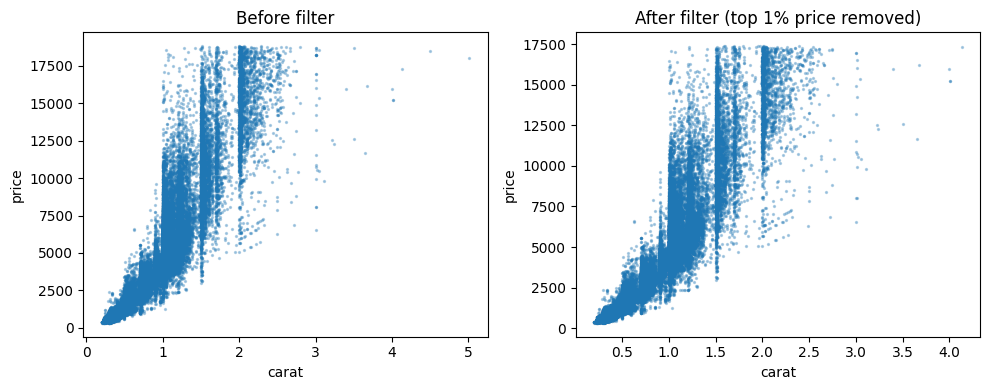

In [10]:
# 練習問題 4-3: フィルタリング前後の carat vs price の散布図

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.scatter(df["carat"], df["price"], alpha=0.3, s=2)
plt.title("Before filter")
plt.xlabel("carat")
plt.ylabel("price")

plt.subplot(1, 2, 2)
plt.scatter(df_filtered["carat"], df_filtered["price"], alpha=0.3, s=2)
plt.title("After filter (top 1% price removed)")
plt.xlabel("carat")
plt.ylabel("price")

plt.tight_layout()
plt.show()

# コメント:
# フィルタリング後は非常に高価格な外れ値が除去され、
# 全体のスケールが圧縮されて分布の傾向が見やすくなっている。


In [11]:
# 練習問題 4-4: rare な cut カテゴリを "Other" に統合する処理例

cut_counts = df_filtered["cut"].value_counts()
print("cut の頻度:")
display(cut_counts)

# 閾値を決めて、それ未満のカテゴリを rare とみなす
threshold = 100  # 例として 100 未満のカテゴリを rare とする
rare_cats = cut_counts[cut_counts < threshold].index.tolist()
print("rare とみなすカテゴリ:", rare_cats)

df_filtered_cut_grouped = df_filtered.copy()
df_filtered_cut_grouped["cut_grouped"] = df_filtered_cut_grouped["cut"].where(
    ~df_filtered_cut_grouped["cut"].isin(rare_cats),
    other="Other"
)

print("\ncut_grouped の頻度:")
display(df_filtered_cut_grouped["cut_grouped"].value_counts())

# 実データでは cut は相対的に均等なので、rare カテゴリは少ない（あるいは存在しない）場合が多い。
# 上記コードは一般的な "rare カテゴリを Other にまとめる" パターンの実装例。


cut の頻度:


cut
Ideal        21374
Premium      13607
Very Good    11962
Good          4861
Fair          1596
Name: count, dtype: int64

rare とみなすカテゴリ: []

cut_grouped の頻度:


cut_grouped
Ideal        21374
Premium      13607
Very Good    11962
Good          4861
Fair          1596
Name: count, dtype: int64

## 5. データ分割（8:2）（練習問題の解答）

In [12]:
# ここではシンプルに carat を説明変数、price を目的変数とする例を用いる

X_single = df_filtered[["carat"]]
y_single = df_filtered["price"]

# 練習問題 5-1: train_test_split で 80% を学習、20% をテストに分割
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
    X_single, y_single, test_size=0.2, random_state=42
)

print("全データ数:", len(X_single))
print("学習データ数 (X_train_s):", len(X_train_s))
print("テストデータ数 (X_test_s):", len(X_test_s))


全データ数: 53400
学習データ数 (X_train_s): 42720
テストデータ数 (X_test_s): 10680


## 6. 単回帰：carat → price（練習問題の解答）

In [13]:
# 線形回帰モデルの定義
lin_single = LinearRegression()

# 練習問題 6-1: 学習データを使って線形回帰モデルを学習し、テストデータの予測値を算出
lin_single.fit(X_train_s, y_train_s)
y_pred_single = lin_single.predict(X_test_s)

print("回帰係数 (coef_):", lin_single.coef_)
print("切片 (intercept_):", lin_single.intercept_)


回帰係数 (coef_): [7536.17177441]
切片 (intercept_): -2126.3736066333627


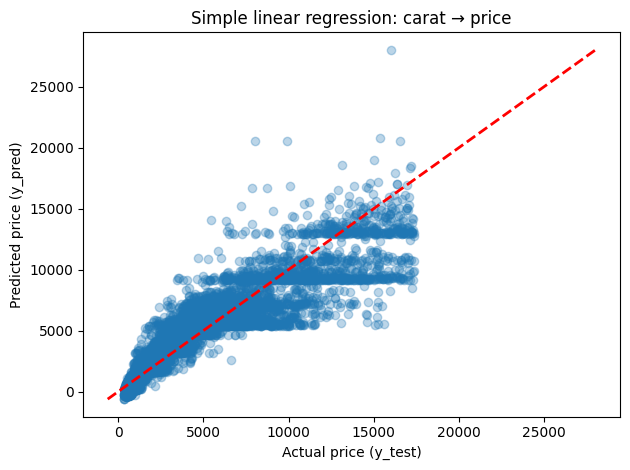

In [14]:
# 練習問題 6-2: 予測値 vs 実測値の散布図
plt.figure()
plt.scatter(y_test_s, y_pred_single, alpha=0.3)
max_val = max(y_test_s.max(), y_pred_single.max())
min_val = min(y_test_s.min(), y_pred_single.min())
plt.plot([min_val, max_val], [min_val, max_val], "r--", linewidth=2)  # x=y の線
plt.xlabel("Actual price (y_test)")
plt.ylabel("Predicted price (y_pred)")
plt.title("Simple linear regression: carat → price")
plt.tight_layout()
plt.show()


In [15]:
# 練習問題 6-3: RMSE と決定係数 R^2 を求める
rmse_single = mean_squared_error(y_test_s, y_pred_single)
r2_single = r2_score(y_test_s, y_pred_single)

print(f"RMSE (simple regression): {rmse_single:.3f}")
print(f"R^2   (simple regression): {r2_single:.3f}")


RMSE (simple regression): 2151349.812
R^2   (simple regression): 0.846


## 7. 重回帰：複数特徴量 → price（練習問題の解答）

In [16]:
# 数値 + カテゴリ特徴量を用いた重回帰

features_numeric = ["carat", "depth", "table", "x", "y", "z"]
features_categorical = ["cut", "color", "clarity"]

X_multi = df_filtered[features_numeric + features_categorical]
y_multi = df_filtered["price"]

# one-hot エンコーディング
X_multi_encoded = pd.get_dummies(X_multi, columns=features_categorical, drop_first=True)

# データ分割
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(
    X_multi_encoded, y_multi, test_size=0.2, random_state=42
)

lin_multi = LinearRegression()

# 練習問題 7-1: モデル学習と予測
lin_multi.fit(X_train_m, y_train_m)
y_pred_multi = lin_multi.predict(X_test_m)

print("学習完了（重回帰モデル）")


学習完了（重回帰モデル）


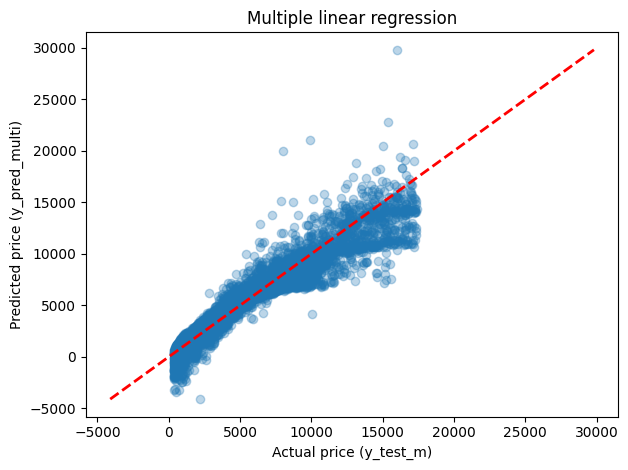

In [17]:
# 練習問題 7-2: 予測値 vs 実測値の散布図
plt.figure()
plt.scatter(y_test_m, y_pred_multi, alpha=0.3)
max_val = max(y_test_m.max(), y_pred_multi.max())
min_val = min(y_test_m.min(), y_pred_multi.min())
plt.plot([min_val, max_val], [min_val, max_val], "r--", linewidth=2)
plt.xlabel("Actual price (y_test_m)")
plt.ylabel("Predicted price (y_pred_multi)")
plt.title("Multiple linear regression")
plt.tight_layout()
plt.show()


In [18]:
# 練習問題 7-3: RMSE と決定係数 R^2
rmse_multi = mean_squared_error(y_test_m, y_pred_multi)
r2_multi = r2_score(y_test_m, y_pred_multi)

print(f"RMSE (multiple regression): {rmse_multi:.3f}")
print(f"R^2   (multiple regression): {r2_multi:.3f}")


RMSE (multiple regression): 1107429.967
R^2   (multiple regression): 0.921


In [19]:
# 練習問題 7-4: coef_ を DataFrame 化し、上位 20 行を確認

coef_df = pd.DataFrame({
    "feature": X_multi_encoded.columns,
    "coef": lin_multi.coef_
}).sort_values("coef", ascending=False)

print("価格を上げる方向に効いている特徴量（上位 20）")
display(coef_df.head(20))

print("価格を下げる方向に効いている特徴量（下位 20）")
display(coef_df.tail(20))

# 係数が正の場合は price を上げる方向、負の場合は下げる方向に働く。
# ただし、多重共線性の影響などもあるため、解釈には注意が必要。


価格を上げる方向に効いている特徴量（上位 20）


,feature,coef
0,carat,10815.131367
4,y,3.820677
2,table,-22.949517
5,z,-29.938594
1,depth,-58.124513
6,cut_Premium,-59.256117
7,cut_Very Good,-101.416742
10,color_E,-195.326896
8,cut_Good,-252.234426
11,color_F,-265.585956


価格を下げる方向に効いている特徴量（下位 20）


,feature,coef
5,z,-29.938594
1,depth,-58.124513
6,cut_Premium,-59.256117
7,cut_Very Good,-101.416742
10,color_E,-195.326896
8,cut_Good,-252.234426
11,color_F,-265.585956
16,clarity_VVS1,-276.765197
17,clarity_VVS2,-329.566101
12,color_G,-456.765752


## 8. LightGBM によるモデル化（練習問題の解答）

In [20]:
# LightGBM を用いた回帰モデル
# すでに作成した X_multi_encoded, y_multi を利用

X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(
    X_multi_encoded, y_multi, test_size=0.2, random_state=42
)

# 練習問題 8-1: ハイパーパラメータをいくつか変化させて RMSE と R^2 を比較
# param_grid という各組み合わせを作ってみる
param_grid = [
    {"n_estimators": 200, "learning_rate": 0.1},
    {"n_estimators": 500, "learning_rate": 0.05},
    {"n_estimators": 800, "learning_rate": 0.03},
]

results = []

for params in param_grid:
    model_lgbm = LGBMRegressor(
        n_estimators=params["n_estimators"],
        learning_rate=params["learning_rate"],
        max_depth=-1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
    )
    model_lgbm.fit(X_train_l, y_train_l)
    y_pred_l = model_lgbm.predict(X_test_l)
    rmse_l = mean_squared_error(y_test_l, y_pred_l)
    r2_l = r2_score(y_test_l, y_pred_l)
    results.append({
        "n_estimators": params["n_estimators"],
        "learning_rate": params["learning_rate"],
        "RMSE": rmse_l,
        "R2": r2_l,
    })

results_df = pd.DataFrame(results)
print("ハイパーパラメータ探索の結果:")
display(results_df.sort_values("RMSE"))


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000749 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1287
[LightGBM] [Info] Number of data points in the train set: 42720, number of used features: 23
[LightGBM] [Info] Start training from score 3791.807491
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000668 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1287
[LightGBM] [Info] Number of data points in the train set: 42720, number of used features: 23
[LightGBM] [Info] Start training from score 3791.807491
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead

,n_estimators,learning_rate,RMSE,R2
2,800,0.03,248241.123464,0.982287
1,500,0.05,249379.279767,0.982206
0,200,0.10,257892.709503,0.981599


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2540
[LightGBM] [Info] Number of data points in the train set: 42720, number of used features: 29
[LightGBM] [Info] Start training from score 3791.807491
拡張特徴量 + LightGBM の RMSE: 251190.292
拡張特徴量 + LightGBM の R^2  : 0.982


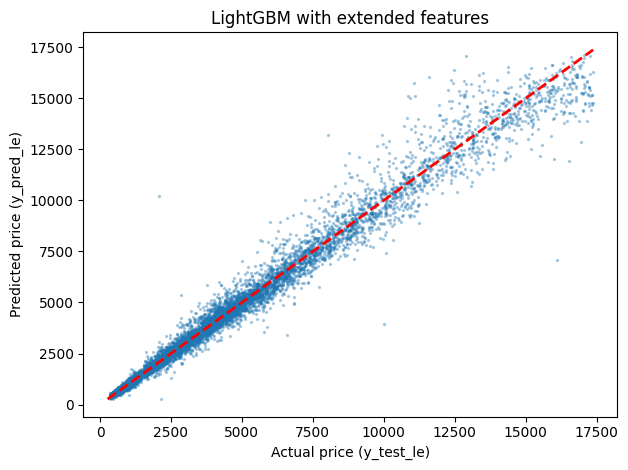

In [21]:
# 練習問題 8-2: 説明変数を変化・追加して高精度なモデルを作成する一例

# 例: 数値特徴量に 2 乗項などの非線形特徴を追加してみる
df_lgbm = df_filtered.copy()

for col in ["carat", "depth", "table", "x", "y", "z"]:
    df_lgbm[f"{col}_sq"] = df_lgbm[col] ** 2

features_numeric_ext = [
    "carat", "depth", "table", "x", "y", "z",
    "carat_sq", "depth_sq", "table_sq", "x_sq", "y_sq", "z_sq"
]
features_categorical = ["cut", "color", "clarity"]

X_lgbm = df_lgbm[features_numeric_ext + features_categorical]
y_lgbm = df_lgbm["price"]

X_lgbm_encoded = pd.get_dummies(X_lgbm, columns=features_categorical, drop_first=True)

X_train_le, X_test_le, y_train_le, y_test_le = train_test_split(
    X_lgbm_encoded, y_lgbm, test_size=0.2, random_state=42
)

best_lgbm = LGBMRegressor(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
)

best_lgbm.fit(X_train_le, y_train_le)
y_pred_le = best_lgbm.predict(X_test_le)

rmse_le = mean_squared_error(y_test_le, y_pred_le)
r2_le = r2_score(y_test_le, y_pred_le)

print(f"拡張特徴量 + LightGBM の RMSE: {rmse_le:.3f}")
print(f"拡張特徴量 + LightGBM の R^2  : {r2_le:.3f}")

plt.figure()
plt.scatter(y_test_le, y_pred_le, alpha=0.3, s=2)
max_val = max(y_test_le.max(), y_pred_le.max())
min_val = min(y_test_le.min(), y_pred_le.min())
plt.plot([min_val, max_val], [min_val, max_val], "r--", linewidth=2)
plt.xlabel("Actual price (y_test_le)")
plt.ylabel("Predicted price (y_pred_le)")
plt.title("LightGBM with extended features")
plt.tight_layout()
plt.show()

# 上記は「特徴量を工夫して LightGBM で性能を高める」一例であり、
# 実際にはより詳細なハイパーパラメータ探索や特徴量エンジニアリングによってさらに精度を向上できる。
